In [ ]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader

In [ ]:
dataset = datasets.MNIST('.', download=True)

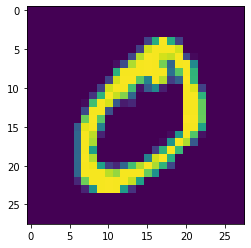

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(dataset.data[1])
plt.show()

# convAE

In [ ]:
# ф-ия обработки батчей
def collate_fn(data: list):
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.unsqueeze(1), 
      'target': target
      }

In [ ]:
# задание гиперпараметров
in_chan = 1
hidden_ch = 32
out_ch = 1
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [ ]:
class Encoder(nn.Module):
  #28*28 -> 14*14 -> 7*7
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    self.conv1 = nn.Conv2d(in_chan, hidden_ch, kernel_size=5, stride=1, padding=2)
    self.pool1 = nn.AvgPool2d(4,4) # сжимает картинку в 4 раза
    self.do1 = nn.Dropout(0.1)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    #self.pool2 = nn.MaxPool2d(2,2) # сжимает картинку в 2 раза
    self.do2 = nn.Dropout(0.1)
    self.conv3 = nn.Conv2d(hidden_ch, out_ch, kernel_size=3, stride=1, padding=1)
    self.activ = nn.Tanh()

  def forward(self, x):
    x = self.do1(self.activ(self.pool1(self.conv1(x))))
    x = self.do2(self.activ(self.conv2(x)))
    x = self.conv3(x)
    return x

class Decoder(nn.Module):
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    self.conv1 = nn.Conv2d(out_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    #self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # обратная операция пулингу
    self.do1 = nn.Dropout(0.1)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=4) # обратная операция пулингу
    self.do2 = nn.Dropout(0.1)
    self.conv3 = nn.Conv2d(hidden_ch, in_chan, kernel_size=5, stride=1, padding=2)
    self.activ = nn.Tanh()

  def forward(self, x):
    x = self.do1(self.activ(self.conv1(x)))
    x = self.do2(self.activ(self.upsample2(self.conv2(x))))
    x = self.conv3(x)
    return x

class ConvAutoEncoder(nn.Module):
    def __init__(self, in_chan, hidden_ch, out_ch):
      super().__init__()
      self.encoder = Encoder(in_chan, hidden_ch, out_ch)
      self.decoder = Decoder(in_chan, hidden_ch, out_ch)

    def forward(self, x):
      hidden = self.encoder(x)
      x_ = self.decoder(hidden)
      return x_

In [ ]:
model_conv = ConvAutoEncoder(in_chan, hidden_ch, out_ch).to(device)
optim = torch.optim.Adam(model_conv.parameters())  # формируем оптимизатор
loss_func = nn.MSELoss()  # определение ф-ии потерь

epoch: 0, step: 0, loss: 0.09074234217405319


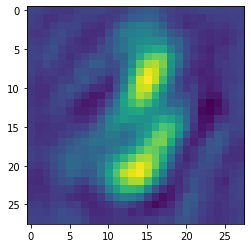

epoch: 1, step: 0, loss: 0.02902897447347641


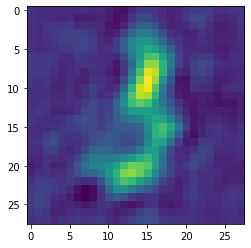

epoch: 2, step: 0, loss: 0.023637322708964348


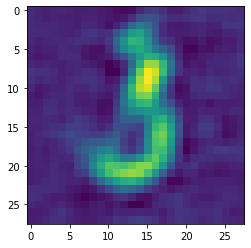

epoch: 3, step: 0, loss: 0.02073902264237404


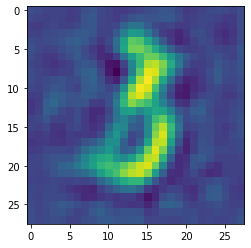

epoch: 4, step: 0, loss: 0.019867928698658943


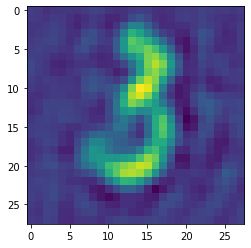

epoch: 5, step: 0, loss: 0.018054908141493797


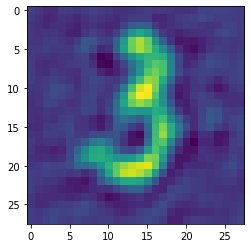

epoch: 6, step: 0, loss: 0.017754793167114258


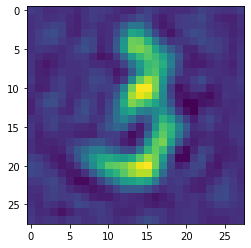

epoch: 7, step: 0, loss: 0.017292125150561333


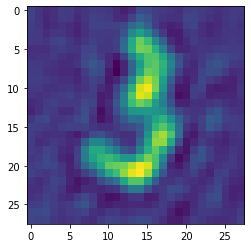

epoch: 8, step: 0, loss: 0.017135251313447952


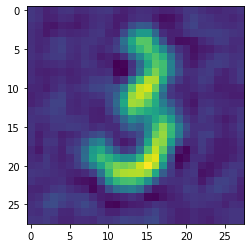

epoch: 9, step: 0, loss: 0.017220154404640198


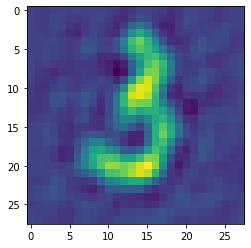

In [ ]:
# процесс обучения
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn,
                          drop_last=True,  # выкидывает последний батч если он меьше заданного размера
                          )
  for i, batch in enumerate(dataloader):
    optim.zero_grad()
    predict = model_conv(batch['data'].to(device))
    loss = loss_func(predict, batch['data'].to(device))
    loss.backward() # расчитывает градиенты
    optim.step()
    if i % 600 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  
  plt.imshow(model_conv((dataset.data[1234].unsqueeze(0).unsqueeze(0) / 255).to(device)).squeeze().cpu().detach().numpy())
  plt.show()
  
  torch.save(model_conv.state_dict(), f'./conv_ae_chkpt_{epoch}.pth')  # сохранение чекпойинта модели

**Вывод:** использование сильного сжатия (в 4 раза) в 1 шаг сильно снижает качество модели, как и использование функции гиперболического тангенса вместо функции релу для функции активации 

# VAE

In [ ]:
# ф-ия обработки батчей
def collate_fn(data: list):
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.unsqueeze(1), 
      'target': target
      }

In [ ]:
# задание гиперпараметров
in_chan = 1
hidden_ch = 32
out_ch = 1
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [ ]:
class Encoder(nn.Module):
  #28*28 -> 14*14 -> 7*7
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    self.conv1 = nn.Conv2d(in_chan, hidden_ch, kernel_size=5, stride=1, padding=2)
    self.pool1 = nn.AvgPool2d(2,2) # сжимает картинку в 2 раза
    self.do1 = nn.Dropout(0.1)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=5, stride=1, padding=2)
    self.pool2 = nn.AvgPool2d(2,2) # сжимает картинку в 2 раза
    self.do2 = nn.Dropout(0.1)
    self.conv_mu = nn.Conv2d(hidden_ch, out_ch, kernel_size=3, stride=1, padding=1)
    self.conv_sigma = nn.Conv2d(hidden_ch, out_ch, kernel_size=3, stride=1, padding=1)
    self.activ1 = nn.ReLU()
    self.activ2 = nn.SiLU()

  def forward(self, x):
    x = self.do1(self.activ1(self.pool1(self.conv1(x))))
    x = self.do2(self.activ2(self.pool2(self.conv2(x))))
    mu = self.conv_mu(x)
    sigma = torch.exp(self.conv_sigma(x))
    return mu, sigma



class Decoder(nn.Module):
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    self.conv1 = nn.Conv2d(out_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # обратная операция пулингу
    self.do1 = nn.Dropout(0.1)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=5, stride=1, padding=2)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # обратная операция пулингу
    self.do2 = nn.Dropout(0.1)
    self.conv3 = nn.Conv2d(hidden_ch, in_chan, kernel_size=5, stride=1, padding=2)
    self.activ1 = nn.ReLU()
    self.activ2 = nn.SiLU()

  def forward(self, x):
    x = self.do1(self.activ2(self.upsample1(self.conv1(x))))
    x = self.do2(self.activ1(self.upsample2(self.conv2(x))))
    x = self.conv3(x)
    return x


def sampling(mu, sigma):
  norm = torch.normal(torch.zeros_like(sigma), torch.ones_like(sigma))
  return mu + sigma * norm

class ConvVarAutoEncoder(nn.Module):
    def __init__(self, in_chan, hidden_ch, out_ch):
      super().__init__()
      self.encoder = Encoder(in_chan, hidden_ch, out_ch)
      self.decoder = Decoder(in_chan, hidden_ch, out_ch)

    def forward(self, x):
      mu, sigma = self.encoder(x)
      hidden = sampling(mu, sigma)
      x_ = self.decoder(hidden)
      return x_, mu, sigma

In [ ]:
model_conv = ConvVarAutoEncoder(in_chan, hidden_ch, out_ch).to(device)
optim = torch.optim.Adam(model_conv.parameters())  # формируем оптимизатор
loss_func = nn.MSELoss()  # определение ф-ии потерь

def kl_loss(mu, sigma):  
  p = torch.distributions.Normal(mu, sigma)
  q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(sigma))

  return torch.distributions.kl_divergence(p, q).mean() # дивергенция кульблика лэйбрера

epoch: 0, step: 0, loss: 0.022769466042518616
epoch: 0, step: 200, loss: 0.023219745606184006
epoch: 0, step: 400, loss: 0.023648642003536224


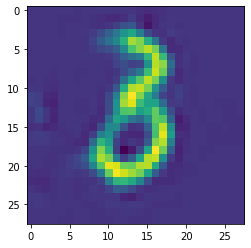

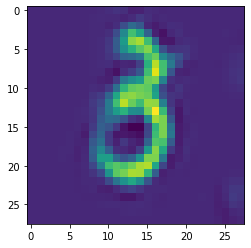

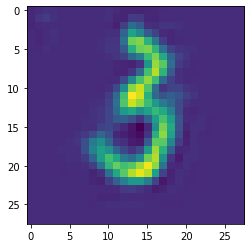

epoch: 1, step: 0, loss: 0.022868867963552475
epoch: 1, step: 200, loss: 0.022798851132392883
epoch: 1, step: 400, loss: 0.023418240249156952


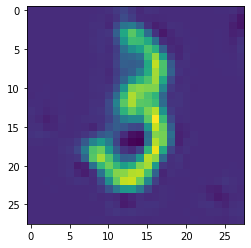

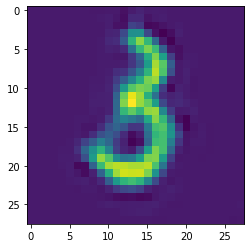

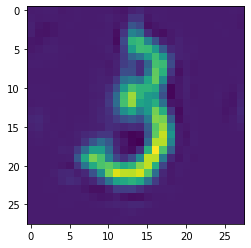

epoch: 2, step: 0, loss: 0.022472430020570755
epoch: 2, step: 200, loss: 0.02269624173641205
epoch: 2, step: 400, loss: 0.022058824077248573


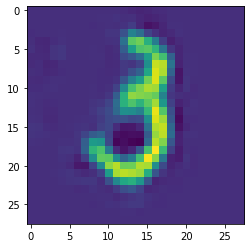

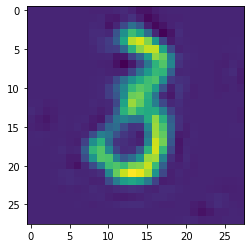

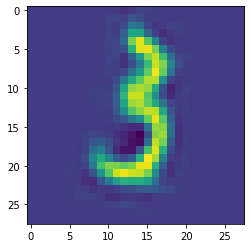

epoch: 3, step: 0, loss: 0.023026637732982635
epoch: 3, step: 200, loss: 0.023160789161920547
epoch: 3, step: 400, loss: 0.022243347018957138


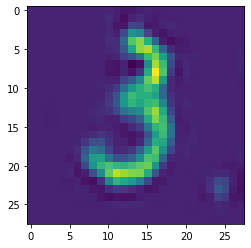

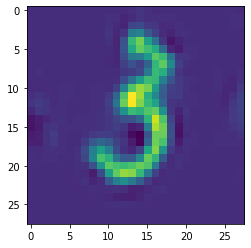

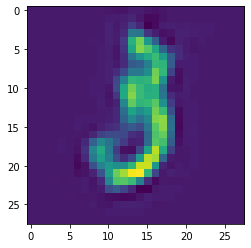

epoch: 4, step: 0, loss: 0.022667571902275085
epoch: 4, step: 200, loss: 0.0221432875841856
epoch: 4, step: 400, loss: 0.02368577942252159


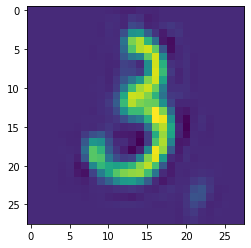

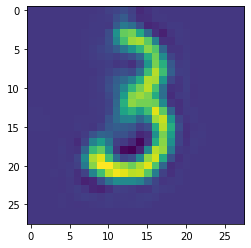

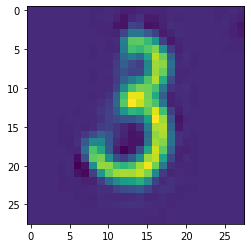

epoch: 5, step: 0, loss: 0.02277088351547718
epoch: 5, step: 200, loss: 0.022595996037125587
epoch: 5, step: 400, loss: 0.022680923342704773


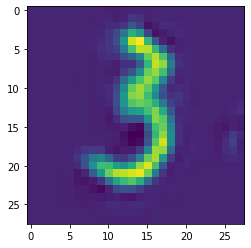

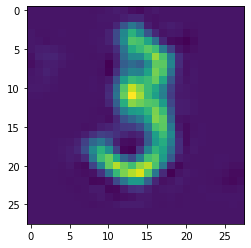

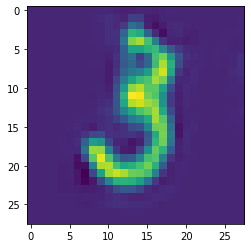

epoch: 6, step: 0, loss: 0.02244798094034195
epoch: 6, step: 200, loss: 0.023269053548574448
epoch: 6, step: 400, loss: 0.023211326450109482


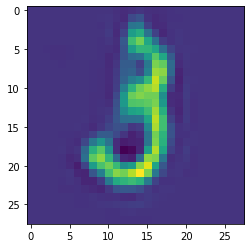

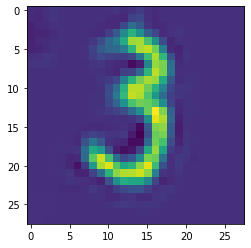

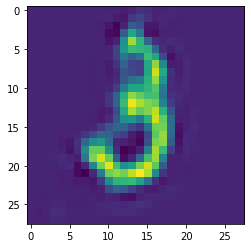

epoch: 7, step: 0, loss: 0.02219861000776291
epoch: 7, step: 200, loss: 0.02244536578655243
epoch: 7, step: 400, loss: 0.022586338222026825


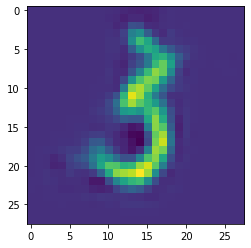

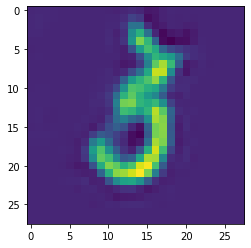

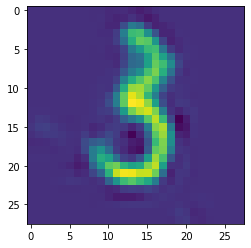

epoch: 8, step: 0, loss: 0.022971289232373238
epoch: 8, step: 200, loss: 0.022378643974661827
epoch: 8, step: 400, loss: 0.02256924659013748


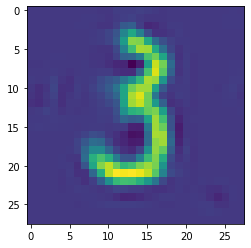

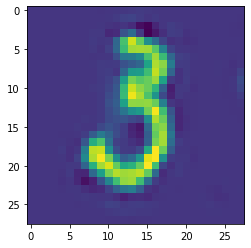

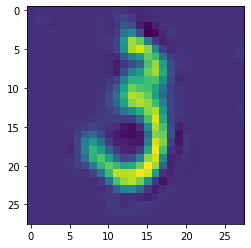

epoch: 9, step: 0, loss: 0.021863412111997604
epoch: 9, step: 200, loss: 0.022735361009836197
epoch: 9, step: 400, loss: 0.022310789674520493


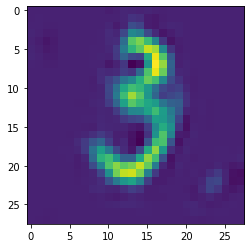

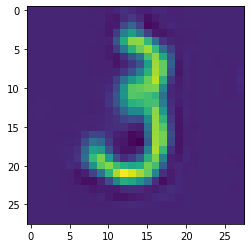

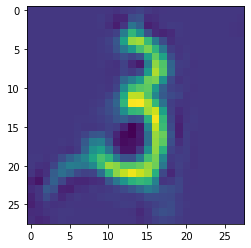

In [ ]:
# процесс обучения
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn,
                          drop_last = True,
                          )
  for i, batch in enumerate(dataloader):
    optim.zero_grad()
    data = batch['data'].to(device)
    # noized = torch.clamp(data + 
    #                      torch.normal(torch.zeros_like(data), 
    #                                   noise_factor * torch.ones_like(data)), 0., 1.)
    predict, mu, sigma = model_conv(data)
    loss = loss_func(predict, data) + 0.01 * kl_loss(mu, sigma)
    loss.backward()
    optim.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  item = dataset.data[1234].unsqueeze(0).unsqueeze(0).float()/255
  mu, sigma = model_conv.encoder(item.to(device))
  # item = torch.normal(torch.zeros((1,1,7,7)), 3 * torch.ones((1,1,7,7)))
  for i in range(3):
    plt.imshow(model_conv.decoder(sampling(mu, sigma))[0].squeeze().cpu().detach().numpy())
    plt.show()
  torch.save(model_conv.state_dict(), f'./conv_ae_chkpt_conv_{epoch}.pth')

**Вывод:** подбор функций активаций и пулинга позволил несколько увеличить качество модели в сравнении с базовой (используемой на занятии)